# Aufgabe 4: POS Tagging und Language Modelling mit HMMs

In dieser Aufgabe werden wir HMMs benutzen, um Wörter aus einem Text mit ihren *part of speech tags* (POS-tags) zu versehen. Auf Deutsch heißt part of speech Wortart. Wir weisen also jedem Wort seine Wortart (Substantiv, Adjektiv, Verb etc.) zu.

Das erscheint erstmal einfach, aber gerade auf Englisch ist es das nicht: Das Wort "house" kann ein Gebäude sein, also ein Substantiv (POS-Tag "NN") oder "Wohnraum breitstellen", also ein Verb (POS-Tag "VB"). Es gibt also Ambiguitäten und wir hoffen, diese mit HMMs auflösen zu können.

POS Tagging ist eine grundlegende Aufgabe in der Sprachverarbeitung und ist oft ein erster Schritt vor weiteren Verarbeitungsschritten.

Wie immer laden wir zuerst Daten:

In [1]:
with open("data.txt", encoding="utf-8") as corpus_file:
    raw_data = [line.lower().strip().split() for line in corpus_file]
full_corpus = raw_data[::2]
full_tagged_corpus = raw_data[1::2]
del raw_data

assert len(full_corpus) == len(full_tagged_corpus)

print(f"{len(full_corpus)} Sätze geladen")

21928 Sätze geladen


Wir trennen einen zufälligen Teil der Daten zum Testen ab. In einer echten Anwendung würden wir die Trennung und das Training N mal mit unterschiedlichen Seeds wiederholen, um auszuschließen, dass wir einen besonders einfachen Split bekommen haben. Wir nennen das [n-fold cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). Hier verzichten wir darauf.

In [2]:
import random
random.seed(1232)
shuffled_indices = random.sample(range(len(full_corpus)), len(full_corpus))
corpus = [full_corpus[i] for i in shuffled_indices]
tagged_corpus = [full_tagged_corpus[i] for i in shuffled_indices]

test_corpus, corpus = corpus[:2000], corpus[2000:]
test_tagged_corpus, tagged_corpus = tagged_corpus[:2000], tagged_corpus[2000:]

Hier ein Beispiel aus den Daten. Es handelt sich um den Penn-Treebank Corpus, ein oft verwendetes Benchmark für POS Tagging. Er besteht aus Texten aus der Financial Times. Eine Liste der Tags und ihre Bedeutung finden Sie [hier](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) (bei uns gibt es noch ein paar mehr weil alle Satzzeichen ihre eigene Klasse haben)

In [3]:
print(corpus[0])
print(list(zip(corpus[0], tagged_corpus[0])))

['discount', 'rate', ':', '7', '%', '.', 'the', 'charge', 'on', 'loans', 'to', 'depository', 'institutions', 'by', 'the', 'new', 'york', 'federal', 'reserve', 'bank', '.']
[('discount', 'nn'), ('rate', 'nn'), (':', ':'), ('7', 'cd'), ('%', 'nn'), ('.', '.'), ('the', 'dt'), ('charge', 'nn'), ('on', 'in'), ('loans', 'nns'), ('to', 'to'), ('depository', 'nn'), ('institutions', 'nns'), ('by', 'in'), ('the', 'dt'), ('new', 'nnp'), ('york', 'nnp'), ('federal', 'nnp'), ('reserve', 'nnp'), ('bank', 'nnp'), ('.', '.')]


Wenn wir mit Textdaten arbeiten, ist es üblich, die Wörter in Indizes umzuwandeln, um nicht überall strings verwenden zu müssen. Dafür müssen wir erstmal feststellen, welche Wörter im Text vorkommen:

In [4]:
from collections import Counter

vocabulary = Counter()
for sentence in corpus:
    vocabulary.update(sentence)

tag_vocabulary = Counter()
for sentence in tagged_corpus:
    tag_vocabulary.update(sentence)

print(f"Im Text kommen {len(vocabulary)} unterschiedliche Wörter und {len(tag_vocabulary)} unterschiedliche tags vor.")
print("Die 10 häufigsten Wörter sind:")
print(vocabulary.most_common(10))

Im Text kommen 41464 unterschiedliche Wörter und 45 unterschiedliche tags vor.
Die 10 häufigsten Wörter sind:
[(',', 53567), ('the', 53148), ('.', 42888), ('of', 25225), ('to', 24567), ('a', 22034), ('in', 18669), ('and', 18116), ("'s", 10269), ('that', 9383)]


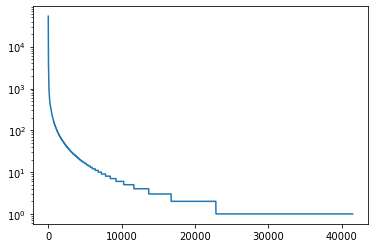

In [6]:
import matplotlib.pyplot as plt
import numpy as np
counts = np.array([count for _, count in vocabulary.most_common()])

plt.figure()
plt.yscale("log")
plt.plot(counts)
plt.show()

Für diese Aufgabe behandeln wir Satzzeichen auch als Wörter. Wir beobachten hier ein Problem, dass sehr typisch für die Sprachverarbeitung ist: Viele der Wörter sind sehr selten. Diese Wörter treiben unseren Speicherverbrauch in die Höhe und weil sie nur ein- oder zweimal vorkommen, können wir auch nichts sinnvolles über sie lernen. Wir verlieren also wenig, wenn wir diese Wörter alle zusammen unter "unknown" zusammenfassen:

In [7]:
cumulative = np.cumsum(counts)
cumulative = cumulative / cumulative[-1]
percentile_index = np.searchsorted(cumulative, 0.95)
print(f"{len(np.where(counts == 1)[0])} Wörter kommen nur einmal vor")
print(f"{percentile_index+1} unterschiedliche Wörter decken 95% des Corpus ab")

18635 Wörter kommen nur einmal vor
10808 unterschiedliche Wörter decken 95% des Corpus ab


Wir fügen dem Vokabular noch zwei Sonderzeichen hinzu: Das schon erwähnte unknown word und ein Sonderzeichen für das Satzende.

In [8]:
vocabulary = ["</s>", "<unk>"] + [word for word, count in vocabulary.most_common(percentile_index+1)]
tag_vocabulary = ["EOS"] + [tag for tag, count in tag_vocabulary.most_common()]

In [9]:
vocabulary_lookup = {word: i for i, word in enumerate(vocabulary)}
tags_lookup = {tag: i for i, tag in enumerate(tag_vocabulary)}

Jetzt schätzen wir die Wahrscheinlichkeiten aus den Daten. Dazu zählen wir
* `start_counts` Wie häufig eine Sequenz mit einem gegebenen Tag anfängt
* `bigram_counts` Wie häufig ein Tag auf ein anderes Tag folgt
* `label_counts` Wie häufig ein Wort ein bestimmtes Tag hat

Für später sammeln wir außerdem
* `word_start_counts` Wie häufig ein Satz mit einem gegeben Wort anfängt
* `word_bigram_counts` Wie häufig ein Wort auf ein anderes folgt

In [10]:
word_start_counts = np.zeros((len(vocabulary),), dtype=int)
word_bigram_counts = np.zeros((len(vocabulary), len(vocabulary)), dtype=int)
tag_start_counts = np.zeros((len(tag_vocabulary),), dtype=int)
tag_bigram_counts = np.zeros((len(tag_vocabulary), len(tag_vocabulary)), dtype=int)
label_counts = np.zeros((len(vocabulary), len(tag_vocabulary)), dtype=int)

for sentence, tagged in zip(corpus, tagged_corpus):
    words = [vocabulary_lookup.get(word, 1) for word in sentence] + [0]
    tags = [tags_lookup[tag] for tag in tagged] + [0]
    
    if len(words) == 0:
        continue

    word_start_counts[words[0]] += 1
    tag_start_counts[tags[0]] += 1
    
    word_pairs = zip(words[:-1], words[1:])
    for first, second in word_pairs:
        word_bigram_counts[first, second] += 1

    tag_pairs = zip(tags[:-1], tags[1:])
    for first, second in tag_pairs:
        tag_bigram_counts[first, second] += 1    
    
    for word, tag in zip(words, tags):
        label_counts[word, tag] += 1


Jetzt schätzen wir Wahrscheinlichkeiten aus den Zählungen. Dabei sehen wir ein zweites häufiges Problem der Sprachverarbeitung: Data sparsity. Obwohl manche Bigramme in der Realität vorkommen könnten, waren sie nicht in den Daten und ihre Wahrscheinlichkeit würde auf 0 geschätzt. Das wird unseren Modellen schaden, deshalb verwenden wir eine smoothing Technik: Wir addieren 1 zu jedem Zähler, als ob jedes Bigramm einmal im Text gesehen worden wäre.

In [23]:
word_start_counts[1:] += 1
word_bigram_counts[1:] += 1
tag_start_counts[1:] += 1
tag_bigram_counts[1:] += 1
label_counts[1:,1:] += 1

word_unigram_counts = label_counts.sum(1)
tag_unigram_counts = label_counts.sum(0)

word_start_probs = word_start_counts / word_start_counts.sum()
word_bigram_probs = word_bigram_counts / word_unigram_counts[:, np.newaxis]
word_label_probs = label_counts / word_unigram_counts[:, np.newaxis]

tag_start_probs = tag_start_counts / tag_start_counts.sum()
tag_bigram_probs = tag_bigram_counts / tag_unigram_counts[:, np.newaxis]
tag_label_probs = label_counts / tag_unigram_counts

In [12]:
class POSTagger:
    # Abstract base class
    def classify(self, sentence):
        # sentence: 1D np.array von Wortindizes
        # return: Gleich langes 1D array mit Tagindizes
        raise NotImplementedError
        
def evaluate(tagger):
    total, correct = 0, 0

    for sentence, tagged in zip(test_corpus, test_tagged_corpus):
        words = np.array([vocabulary_lookup.get(word, 1) for word in sentence] + [0])
        labels = np.array([tags_lookup[tag] for tag in tagged])

        prediction = tagger.classify(words)

        total += len(labels)
        correct += np.sum(prediction[:-1] == labels)

    print(f"Accuracy: {correct / total:.1%}")

Wir wollen zuerst eine einfache Methode testen (wir nennen das eine Baseline): Wir weisen einfach jedem Wort das am häufigsten gesehene Tag zu.

In [13]:
class SimpleTagger(POSTagger):
    def __init__(self, assignment_probs):
        self.assignments = assignment_probs.argmax(1)
    
    def classify(self, sentence):
        sequence = self.assignments[sentence]
        return sequence

evaluate(SimpleTagger(word_label_probs))

Accuracy: 88.6%


Die Baseline ist schon relativ stark. Hoffentlich kann das HMM noch etwas besser sein. Wir modellieren das Problem wie folgt:

Die Wörter sind die Ausgaben des HMM, die wir beobachten können. Die POS tags sind die versteckten Zustände. Wir benutzen den *Viterbi-Algorithmus*, um die wahrscheinlichste Zustandsfolge (Tag-Folge) für eine Beobachtung (Wortfolge) zu bestimmen.

Wir werden den EOS Zustand (Zustand 0) als den Start- und Endzustand benutzen. Dafür kopieren wir die Verteilung der Start-Tags als die Übergangswahrscheinlichkeiten dieses Startzustands.

In [14]:
transition_probs = np.copy(tag_bigram_probs)
transition_probs[0] = tag_start_probs

emission_probs = tag_label_probs

Um den Algorithmus in der Praxis verwenden zu können, müssen wir aber eine Beobachtung machen: $v_t$ ist eine Multiplikation von Wahrschinlichkeiten und wird schon nach ca. 20 Schritten kleiner werden als die Präzision eines `double`. Deswegen benutzen wir *log-Wahrscheinlichkeiten*, wir berechnen also $\log v_t$ statt $v_t$. Machen Sie sich klar, wie sich dabei die Formeln verändern.

### Aufgabe a) (20 Punkte)
Implementieren Sie den Viterbi Algorithmus. Wichtig: Verwenden Sie dabei die Log-Wahrschinlichkeiten!

In [16]:
class HMM(POSTagger):
    def __init__(self, transition, emission):
        self.transition = transition
        self.emission = emission
        self.num_emissions, self.num_states = emission.shape
        assert self.transition.shape == (self.num_states, self.num_states)
        assert self.emission.shape == (self.num_emissions, self.num_states)
        self.log_transition = np.log2(transition)
        self.log_emission = np.log2(emission)

    def classify(self, observation):
        length = len(observation)
        psi = np.zeros((length, self.num_states), dtype=np.int)
        delta = np.full((self.num_states,), float("-inf"))
        delta[0] = 0
        
        for t in range(length):
            inner = delta[:, np.newaxis] + self.log_transition
            delta = np.max(inner, 0) + self.log_emission[observation[t]]
            psi[t] = np.argmax(inner, 0)
        
        best_path = np.empty((length,), dtype=np.int)
        best_path[length-1] = np.argmax(delta)
        for t in reversed(range(1, length)):
            best_path[t-1] = psi[t, best_path[t]]
        return best_path
    
    def score(self, observation):
        length = len(observation)
        alpha = np.zeros((self.num_states,))
        alpha[0] = 1
        c = np.zeros((length,))
        for t in range(length):
            alpha = np.dot(alpha, self.transition) * self.emission[observation[t]]
            c[t] = alpha.sum()
            alpha /= c[t]
        return np.log2(c).sum() + np.log2(alpha[0])
    
    def _score(self, observation):
        length = len(observation)
        alpha = np.zeros((self.num_states,))
        alpha[0] = 1
        for t in range(length):
            alpha = np.dot(alpha, self.transition) * self.emission[observation[t]]
        return np.log2(alpha.sum())

In [17]:
# Wir haben Nullwahrscheinlichkeiten, die beim Logarithmus Warnungen produzieren
import warnings
warnings.filterwarnings("ignore", "divide by zero") 

hmm = HMM(transition_probs,
          emission_probs)

Sie können Ihre Implementierung an diesem Beispiel testen:

In [18]:
words = np.array([vocabulary_lookup.get(word, 1) for word in corpus[1000]] + [0])

np.testing.assert_equal(hmm.classify(words),
                           np.array([ 3,  3,  7,  9,  6,  5,  7, 11,  5,  1,  2,  4,  1,  2,  6, 13,  5,
                                      6,  2,  9, 14,  9,  8, 17, 20, 12,  2,  4,  1,  8,  0]))
# Log-Wahrscheinlichkeit des Viterbi-Pfads ist -246.277

In [19]:
evaluate(hmm)

Accuracy: 91.7%


Wenn Ihre Implementierung stimmt, sollte das HMM eine höhere Accuracy als die Baseline erreicht haben.

### Language Modeling

Ein Sprachmodell bestimmt $P(w)$, also die Wahrscheinlichkeit, dass eine bestimmte Wortfolge auftritt. Wir können tatsächlich das gleiche HMM für die Sprachmodellierung einsetzen. Zuerst definieren wir wieder eine abstrakte Klasse und die Evaluation:

In [20]:
class LanguageModel:
    def score(self, sentence):
        # sentence: 1D np.array von Wortindizes
        # return: Skalar. log-Wahrscheinlichkeit dieses Satzes
        raise NotImplementedError

def evaluate_lm(lm):
    entropy, total = 0, 0
    
    for sentence in test_corpus:
        words = np.array([vocabulary_lookup.get(word, 1) for word in sentence] + [0])

        lprob = lm.score(words)
        if lprob == float("-inf"):
            print(words)

        total += len(words)
        entropy -= lprob

    print(f"Perplexity: {2 ** (entropy / total):.1f}")

Wir wollen diesmal zwei Baselines vergleichen: Ein Unigram- und ein Bigramm-Sprachmodell. Das Unigramm-Modell hat weniger Parameter als das HMM (es hat genau $V$ Parameter, das HMM hat $T+T^2+V\cdot T$) und das Bigramm-Modell hat mehr ($V^2$).

In [21]:
class UnigramLanguageModel(LanguageModel):
    def __init__(self, unigram_probs):
        self.unigram_probs = np.log2(unigram_probs)
    
    def score(self, sentence):
        return self.unigram_probs[sentence].sum()

evaluate_lm(
    UnigramLanguageModel(
        word_unigram_counts / word_unigram_counts.sum())
)

Perplexity: 731.2


In [24]:
class BigramLanguageModel(LanguageModel):
    def __init__(self, start_probs, bigram_probs):
        self.start_probs = np.log2(start_probs)
        self.bigram_probs = np.log2(bigram_probs)
    
    def score(self, sentence):
        lprob = self.start_probs[sentence[0]]
        lprob += self.bigram_probs[sentence[:-1], sentence[1:]].sum()
        return lprob

evaluate_lm(
    BigramLanguageModel(
        word_start_probs,
        word_bigram_probs)
)

Perplexity: 78.0


### Aufgabe b1) Zusammen mit b2 20 Punkte

Erweitern Sie Ihre HMM Implementierung so, dass Sie ein Sprachmodell implementiert. Verwenden Sie dafür den *Forward-Algorithmus*. Machen Sie sich klar, warum Sie hier keine log-Wahrscheinlichkeiten benutzen können.

In [25]:
evaluate_lm(hmm)

Perplexity: 522.4


Wahrscheinlich hat die Evaluation eine Warnung und eine Perplexität von unendlich erzeugt. Das liegt an dem Problem, das wir oben beim Viterbi Algorithmus beschrieben hatten: Die $\alpha_t$ werden zu klein, um von `double`s dargestellt zu werden.

Da wir beim Forward-Algorithmus keine log-Wahrscheinlichkeiten verwenden können, müssen wir eine andere Technik einführen: Skalierung.

Wir erweitern den Forward Algorithmus wie folgt:
1. Für ein gegebenes $t$, berechne die $\alpha_t$.
2. Berechne $c_t = \sum_j \alpha_t(j)$.
3. Normalisiere die $\alpha_t$ zu $\hat{\alpha}_t$ mit $\hat{\alpha}_t(j) = \frac{\alpha_t(j)}{c_t}$
4. Verwende für die Berechnung der $\alpha_{t+1}$ die $\hat{\alpha}_t$ statt $\alpha_t$.

Um $P(O|\lambda)$ zu bestimmen, können wir jetzt nicht mehr $\hat{\alpha}_T(0)$ nehmen, da es bereits skaliert ist. Genauso können wir nicht einfach ent-skalieren, denn den echten Wert können wir wieder numerisch nicht ausdrücken. Wir können aber durch Induktion zeigen, dass $\hat{\alpha}_t(j)=\left(\prod_{\tau=1}^t \frac{1}{c_\tau}\right)\alpha_t(j)$. Daher:

$$P(O|\lambda) = \alpha_T(0) = \hat{\alpha}_T(0) \prod_{\tau=1}^T c_\tau$$

Also

$$\log P(O|\lambda) = \log \hat{\alpha}_T(0) + \sum_{\tau=1}^T \log c_\tau$$

Wir können also die Log-Wahrscheinlichkeit bestimmen, die für die Sprachmodellierung ausreicht.

### Aufgabe b2)
Implementieren Sie den Forward-Algorithmus mit Skalierung. Hinweis: Für die korrekte Berechnung der Perplexität, verwenden Sie den Logarithmus zur Basis 2 (`np.log2`). Wenn Ihre Implementierung korrekt ist, sollte die Perplexität des HMM-Sprachmodells zwischen der des Unigramm- und der des Bigramm-Sprachmodells liegen.

Sie können Ihre Implementierung an diesem Beispiel testen:

In [26]:
words = np.array([vocabulary_lookup.get(word, 1) for word in corpus[1000]] + [0])

score = hmm.score(words)
assert abs(score + 243.095) < 1e-3, score